In [59]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import copy
import random
import importlib
import algos as al
import imageio

importlib.reload(al) 

<module 'algos' from 'e:\\WindyPostmanProblem\\algos.py'>

In [60]:
def initialize_edge_weights(graph):
    """Set all edge weights to 0 for visualization."""
    for u, v in graph.edges():
        graph[u][v]['weight'] = 0

In [61]:
def get_highest_degree_node(graph):
    """Return the node with the highest degree in the graph."""
    degrees = dict(graph.degree())
    return max(degrees, key=degrees.get)

In [77]:
def multiple_probabilistic_walks(graph, num_walks, steps):
    """Simulate multiple random walks on the weighted graph."""
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node

    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [graph[current_node][neighbor].get('weight', 1) for neighbor in neighbors]

            # Normalize weights to create probabilities
            probabilities = [weight / sum(weights) if sum(weights) != 0 else 1 / len(weights) for weight in weights]
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    for i in range (90):
        snapshot = copy.deepcopy(snapshots[-1])
        snapshots.append(snapshot)
    
    return snapshots 

In [63]:
def compute_max_weights(snapshots):
    """Compute the maximum weight for each edge across all snapshots."""
    max_weights = {}
    for snapshot in snapshots:
        for u, v, data in snapshot.edges(data=True):
            edge = (min(u, v), max(u, v))
            weight = data.get('weight', 0)
            if edge not in max_weights:
                max_weights[edge] = weight
            else:
                max_weights[edge] = max(max_weights[edge], weight)
    return max_weights

In [78]:
def visualize_graph(snapshot, ax, max_weight, starting_node=None):
    """Visualize a single snapshot of the graph with edge opacity and color based on current weight."""
    ax.clear()  # Clear the previous frame
    pos = nx.spring_layout(snapshot, seed=42, weight=None)  # Fixed layout for consistency
    
    # Get edge weights for the current snapshot
    edge_weights = np.array([snapshot[u][v]['weight'] for u, v in snapshot.edges()])

    # Create a colormap for edge weights
    cmap = plt.cm.plasma
    min_weight = 0.1  # Minimum weight to ensure edges are visible
    weight_factor = 3  # Adjust this factor to enhance color intensity
    
    # Minimum and maximum opacity values
    min_opacity = 0.1  # Set a minimum opacity for visibility
    max_opacity = 1.0  # Fully opaque for the highest weights

    # Scale weights for color mapping
    edge_weights = np.maximum(edge_weights, min_weight)  # Avoid weights below minimum
    
    # Normalize edge weights for color and opacity calculation
    scaled_weights = edge_weights * weight_factor  # Scale weights for color mapping
    
    # Calculate opacity based on edge weights relative to max weight in the last snapshot
    opacities = min_opacity + (edge_weights / max_weight) * (max_opacity - min_opacity)
    
    # Get colors from the colormap and apply opacity
    edge_colors = [(*cmap(weight / max_weight)[:3], opacity) 
                   for weight, opacity in zip(scaled_weights, opacities)]

    # Draw edges with colors and transparency based on weights
    nx.draw_networkx_edges(snapshot, pos, edge_color=edge_colors, width=2, ax=ax)

    # Draw nodes, differentiating the starting node with a different color
    node_colors = ['red' if node == starting_node else 'skyblue' for node in snapshot.nodes()]
    nx.draw_networkx_nodes(snapshot, pos, node_color=node_colors, node_size=100, ax=ax)

    # Turn off the axis
    plt.axis('off')


In [80]:
def animate_walks(snapshots, save_gif=True, filename="multiple_walks.gif", fps=5):
    """Animate the snapshots of graph walks and save as a GIF if desired."""
    # Create a figure for visualization
    fig, ax = plt.subplots(figsize=(18, 8), facecolor='#3e3e3e')
    last_snapshot = snapshots[-1]
    max_weight = max([last_snapshot[u][v]['weight'] for u, v in last_snapshot.edges()])
    starting_node = get_highest_degree_node(snapshots[0]) 
    
    # Update function to visualize each snapshot
    def update(frame):
        ax.clear()  # Clear the previous frame
        visualize_graph(snapshots[frame], ax, max_weight,starting_node)  # Visualize the current snapshot
        plt.title(f"Frame {frame + 1}", color='white')  # Update title with current step number
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(snapshots), interval=300, repeat=False)

    # Show or save the animation
    if save_gif:
        writer = PillowWriter(fps=fps)
        ani.save(filename, writer=writer)
        print(f"Animation saved as {filename}")
    else:
        plt.show()

Graph with 200 nodes and 235 edges
Animation saved as new_on_35_fps.gif


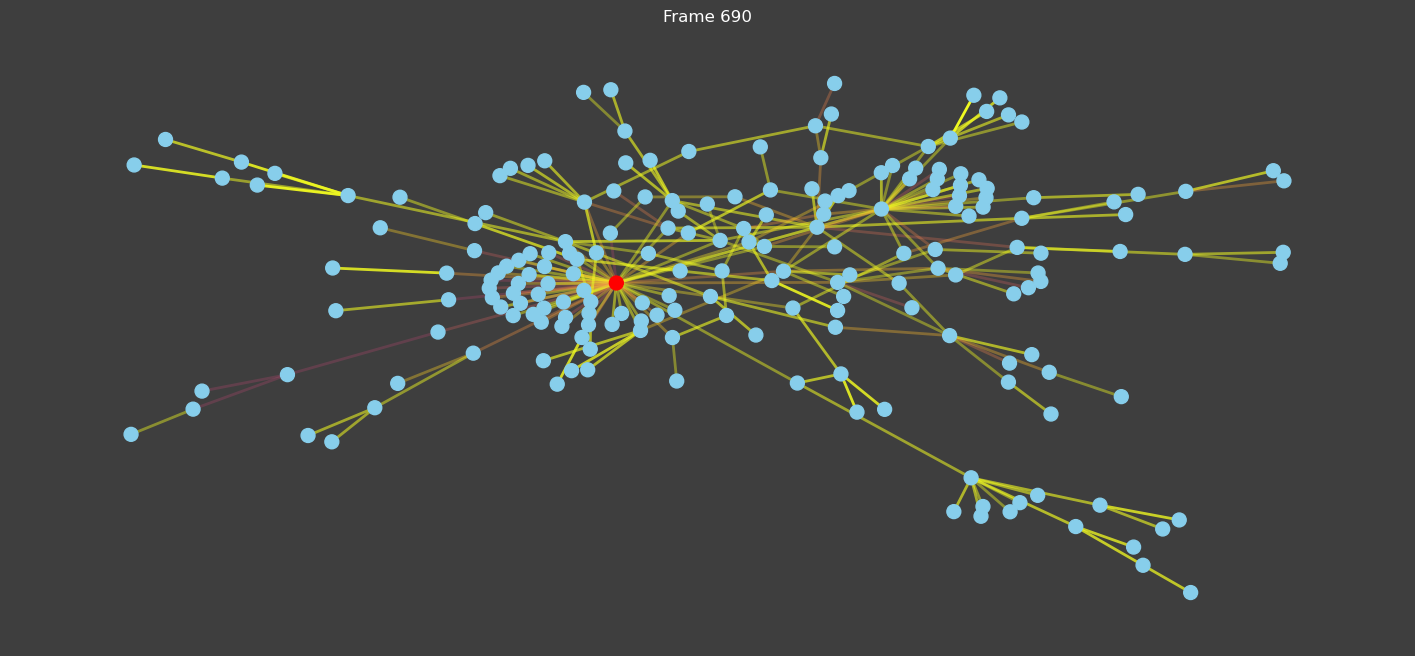

In [82]:
G = al.generate_sf_graph(200)
al.add_weights_to_edges_from_dict(G,nx.degree_centrality(nx.line_graph(G)))

snapshots = multiple_probabilistic_walks(G, num_walks=10, steps=600)
animate_walks(snapshots,  filename="new_on_35_fps.gif",fps=37)